In [ ]:
!pip install tensorflow-gan

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
# Helper libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import tensorflow_datasets as tfds
import os
import PIL
import PIL.Image
import keras
import gc
from PIL import Image

In [ ]:
#Start by connecting gdrive into the google colab
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
os.chdir("/content/gdrive/MyDrive/Saved images")
!pwd

/content/gdrive/MyDrive/Saved images


In [ ]:
"""
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/celeba.zip', 'r')
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()
"""

"\nimport zipfile\nimport os\n\nzip_ref = zipfile.ZipFile('/content/gdrive/MyDrive/celeba.zip', 'r')\nzip_ref.extractall('/tmp') #Extracts the files into the /tmp folder\nzip_ref.close()\n"

In [ ]:
dataset = tf.data.Dataset.list_files('/tmp/img_align_celeba/*.jpg', shuffle=True)
image_count = len(os.listdir('/tmp/img_align_celeba/'))

scale = 1.0
dataset = dataset.take(int(image_count * scale))
val_size = int(image_count * scale * 0.1)
trainData = dataset.skip(int(val_size))
valData = dataset.take(val_size)

In [ ]:
def decode_img(file_path):
  img = tf.io.read_file(file_path)
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.crop_to_bounding_box(img, 20, 0, 178, 178)
  #img = tf.image.rgb_to_grayscale(img)
  img = img / 255
  # resize the image to the desired size
  return tf.image.resize(img, [96, 96])

trainData = trainData.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
valData = valData.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
compare_size = 256
k = 0
real_images = np.empty((256, 96, 96, 3))
for batch in trainData:
  #plt.imshow(batch)
  real_images[k] = batch.numpy()
  k = k + 1
  if (k == compare_size):
    break

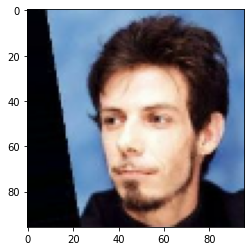

In [ ]:
plt.imshow(real_images[0])

In [ ]:
SEED_SIZE = 100
generator1 = keras.models.load_model("/content/gdrive/MyDrive/generator-VLSGAN", compile=False)
#generator2 = keras.models.load_model("/content/gdrive/MyDrive/generator-VL2", compile=False)
#generator3 = keras.models.load_model("/content/gdrive/MyDrive/generator-v2", compile=False)

In [ ]:
"""
noise = tf.random.normal([1, SEED_SIZE])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0])
#plt.savefig("generatedImage")
"""

'\nnoise = tf.random.normal([1, SEED_SIZE])\ngenerated_image = generator(noise, training=False)\nplt.imshow(generated_image[0])\n#plt.savefig("generatedImage")\n'

In [ ]:
noise = tf.random.normal([compare_size, SEED_SIZE])
generated_images1 = generator1(noise, training=False).numpy()
noise = tf.random.normal([compare_size, SEED_SIZE])
generated_images2 = generator1(noise, training=False).numpy()
noise = tf.random.normal([compare_size, SEED_SIZE])
generated_images3 = generator1(noise, training=False).numpy()

In [ ]:
real_images = np.rollaxis(real_images, 3, 1)  
generated_images1 = np.rollaxis(generated_images1, 3, 1) 
generated_images2 = np.rollaxis(generated_images2, 3, 1) 
generated_images3 = np.rollaxis(generated_images3, 3, 1) 

In [ ]:
test1 = real_images * 255
generated_images1 = generated_images1*255
generated_images2 = generated_images2*255
generated_images3 = generated_images3*255

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import os
import functools
import numpy as np
import time
from tensorflow.python.ops import array_ops
# pip install tensorflow-gan
import tensorflow_gan as tfgan

session=tf.compat.v1.InteractiveSession()
# A smaller BATCH_SIZE reduces GPU memory usage, but at the cost of a slight slowdown
BATCH_SIZE = 64

# Run images through Inception.
inception_images = tf.compat.v1.placeholder(tf.float32, [None, 3, None, None], name = 'inception_images')
activations1 = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'activations1')
activations2 = tf.compat.v1.placeholder(tf.float32, [None, None], name = 'activations2')
fcd = tfgan.eval.frechet_classifier_distance_from_activations(activations1, activations2)

INCEPTION_TFHUB = 'https://tfhub.dev/tensorflow/tfgan/eval/inception/1'
INCEPTION_FINAL_POOL = 'pool_3'

def inception_activations(images = inception_images, num_splits = 1):
    images = tf.transpose(images, [0, 2, 3, 1])
    size = 299
    images = tf.compat.v1.image.resize_bilinear(images, [size, size])
    generated_images_list = array_ops.split(images, num_or_size_splits = num_splits)
    activations = tf.map_fn(
        fn = tfgan.eval.classifier_fn_from_tfhub(INCEPTION_TFHUB, INCEPTION_FINAL_POOL, True),
        elems = array_ops.stack(generated_images_list),
        parallel_iterations = 1,
        back_prop = False,
        swap_memory = True,
        name = 'RunClassifier')
    activations = array_ops.concat(array_ops.unstack(activations), 0)
    return activations

activations =inception_activations()

def get_inception_activations(inps):
    n_batches = int(np.ceil(float(inps.shape[0]) / BATCH_SIZE))
    act = np.zeros([inps.shape[0], 2048], dtype = np.float32)
    for i in range(n_batches):
        inp = inps[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] / 255. * 2 - 1
        act[i * BATCH_SIZE : i * BATCH_SIZE + min(BATCH_SIZE, inp.shape[0])] = session.run(activations, feed_dict = {inception_images: inp})
    return act

def activations2distance(act1, act2):
    return session.run(fcd, feed_dict = {activations1: act1, activations2: act2})
        
def get_fid(images1, images2):
    session=tf.get_default_session()
    assert(type(images1) == np.ndarray)
    assert(len(images1.shape) == 4)
    assert(images1.shape[1] == 3)
    assert(np.min(images1[0]) >= 0 and np.max(images1[0]) > 10), 'Image values should be in the range [0, 255]'
    assert(type(images2) == np.ndarray)
    assert(len(images2.shape) == 4)
    assert(images2.shape[1] == 3)
    assert(np.min(images2[0]) >= 0 and np.max(images2[0]) > 10), 'Image values should be in the range [0, 255]'
    assert(images1.shape == images2.shape), 'The two numpy arrays must have the same shape'
    print('Calculating FID with %i images from each distribution' % (images1.shape[0]))
    start_time = time.time()
    act1 = get_inception_activations(images1)
    act2 = get_inception_activations(images2)
    fid = activations2distance(act1, act2)
    print('FID calculation time: %f s' % (time.time() - start_time))
    return fid


Instructions for updating:
non-resource variables are not supported in the long term



/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:513: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '
/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


In [ ]:
fid = []
fid.append(get_fid(test1, generated_images1))
fid.append(get_fid(test1, generated_images2))
fid.append(get_fid(test1, generated_images3))

Calculating FID with 256 images from each distribution
FID calculation time: 129.616933 s
Calculating FID with 256 images from each distribution
FID calculation time: 124.971513 s
Calculating FID with 256 images from each distribution
FID calculation time: 123.894306 s


In [ ]:
fid

[87.65907, 87.92429, 83.52004]